In [2]:
%cd ..

/Users/treycole/Codes/WanPy


In [3]:
from WanPy.WanPy import *
import WanPy.models as models
import WanPy.plotting as plot

from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sympy as sp 
import scipy
import os
cwd = os.getcwd()

In [92]:
delta = 1
t0 = 0.4
tprime = 0.5

model = models.chessboard(t0, tprime, delta).make_supercell([[2,0], [0,2]])

orbs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)
lat_vecs = model.get_lat() # lattice vectors

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)

In [93]:
u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print(f"Chern number: {chern:.2f}")

Chern number: -1.00


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': "$C = -1.0$ | $\\Delta = 1,\\ t_0 = 0.4,\\ t' = 0.5$"}, ylabel='Energy $E(\\mathbf{{k}})$ '>)

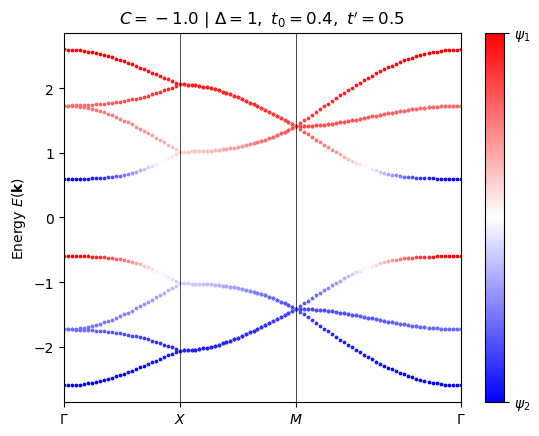

In [94]:
k_path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
k_label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')

title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$")

plot.plot_bands(
    model, k_path=k_path, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

In [95]:
# 2D k-mesh
nkx = 20
nky = 20
Nk = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

u_wfs_Wan = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_Wan.solve_on_one_point(k_mesh[i,j], [i,j])

In [96]:
omit_sites = None
tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site

tf_list = gen_rand_tf_list(3, n_orb)

In [97]:
w0, psi_til_wan = Wannierize(orbs, u_wfs_Wan, tf_list, ret_psi_til=True)
u_tilde_wan = get_bloch_wfs(orbs, psi_til_wan, k_mesh, inverse=True)

In [98]:
M = k_overlap_mat(lat_vecs, orbs, u_tilde_wan) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(lat_vecs, M, decomp=True)

print(rf"Spread from M_kb of \tilde{{u_nk}} = {spread[0]}")
print(rf"Omega_I from M_kb of \tilde{{u_nk}} = {spread[1]}")
print(rf"Omega_til from M_kb \tilde{{u_nk}} = {spread[2]}")

Spread from M_kb of \tilde{u_nk} = 3.7430908211254548
Omega_I from M_kb of \tilde{u_nk} = 2.201956438098847
Omega_til from M_kb \tilde{u_nk} = 1.5411343830265987


In [99]:
# spread, expc_rsq, expc_r_sq = spread_real(lat_vecs, orbs, w0, decomp=True)

# print(rf"Spread from w0 = {spread[0]}")
# print(rf"Omega_I from w0 = {spread[1]}")
# print(rf"Omega_til from w0 = {spread[2]}")

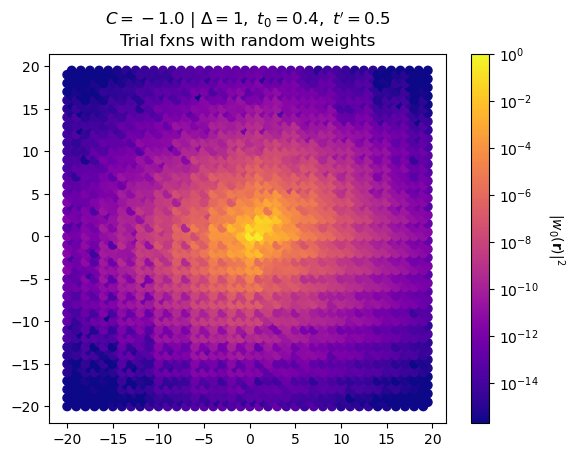

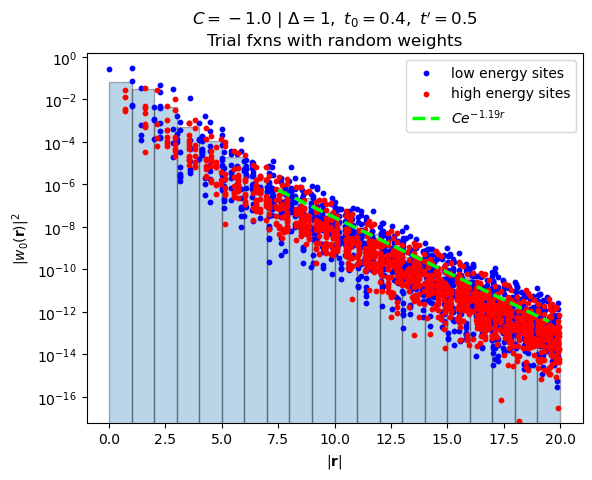

In [101]:
idx = 0
# title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$"
#         "\n" 
#         rf"Trial fxns on sites {tf_list}"
#          )
title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$"
        "\n" 
        rf"Trial fxns with random weights"
         )
save_name = f'w_{idx}_scatter_C={chern:.1f}_Delta={delta}_t0={t0}_tprime={tprime}_tfxs={tf_list}.png'

fig, ax = plot.plot_Wan(w0, idx, orbs, lat_vecs, title=title, plot_phase=False, plot_decay=True, fit_rng=[7, 20])

In [102]:
# outer window of entangled bands is full occupied manifold
iter_num_omega_i = 10000
iter_num_omega_til = 10000
save_name = f'C={chern:.1f}_Delta={delta}_t0={t0}_tprime={tprime}_tfxs={tf_list}_iter_num_omega_i={iter_num_omega_i}_iter_num_omega_til={iter_num_omega_til}.npy'
save_name = f'C={chern:.1f}_Delta={delta}_t0={t0}_tprime={tprime}_tfxs=rand_2_iter_num_omega_i={iter_num_omega_i}_iter_num_omega_til={iter_num_omega_til}.npy'
outer_states = u_wfs_Wan._wfs[..., :n_occ, :]

W0_max_loc, u_wf_max_loc, Wf_cntrs = max_loc_Wan(lat_vecs, orbs, u_wfs_Wan, tf_list, outer_states, 
        iter_num_omega_i=iter_num_omega_i, iter_num_omega_til=iter_num_omega_til,
        Wan_idxs=None, verbose=True, return_uwfs=True, return_wf_centers=True, eps=2e-3,
        save=True, save_name=save_name
        )

0 Omega_I: 2.120763051657065
1 Omega_I: 2.049747209968585
2 Omega_I: 1.9864121055941846
3 Omega_I: 1.9292816081833541
4 Omega_I: 1.877342968199526
5 Omega_I: 1.8298434744664673
6 Omega_I: 1.7861942564910103
7 Omega_I: 1.7459184345024965
8 Omega_I: 1.7086205202739437
9 Omega_I: 1.673966997238438
10 Omega_I: 1.6416732105149066
11 Omega_I: 1.6114940383195293
12 Omega_I: 1.5832169559492306
13 Omega_I: 1.5566566921728056
14 Omega_I: 1.5316509961107172
15 Omega_I: 1.5080572115639772
16 Omega_I: 1.4857494600270287
17 Omega_I: 1.4646162964856164
18 Omega_I: 1.4445587413787029
19 Omega_I: 1.4254886175027417
20 Omega_I: 1.4073271376705259
21 Omega_I: 1.3900037007746457
22 Omega_I: 1.3734548624201721
23 Omega_I: 1.3576234526219668
24 Omega_I: 1.3424578179047564
25 Omega_I: 1.3279111689472294
26 Omega_I: 1.3139410179596502
27 Omega_I: 1.3005086924706994
28 Omega_I: 1.2875789142544958
29 Omega_I: 1.275119433843681
30 Omega_I: 1.2631007125179328
31 Omega_I: 1.251495644875257
32 Omega_I: 1.2402793161

In [29]:
# save_name = f'C={chern:.1f}_Delta={delta}_t0={t0}_tprime={tprime}_tfxs=rand_iter_num_omega_i={5000}_iter_num_omega_til={5000}.npy'

# sv_dir = 'data'
# if not os.path.exists(sv_dir):
#     os.makedirs(sv_dir)
# sv_prefix = 'W0_max_loc'
# np.save(f"{sv_dir}/{sv_prefix}_{save_name}", W0_max_loc)
# sv_prefix = 'W0_max_loc_cntrs'
# np.save(f"{sv_dir}/{sv_prefix}_{save_name}", Wf_cntrs)
# # sv_prefix = 'u_wfs_max_loc'
# # np.save(f"{sv_dir}/{sv_prefix}_{save_name}", Wf_cntrs)

Center [ 9.998373e-01 -2.000000e-07]


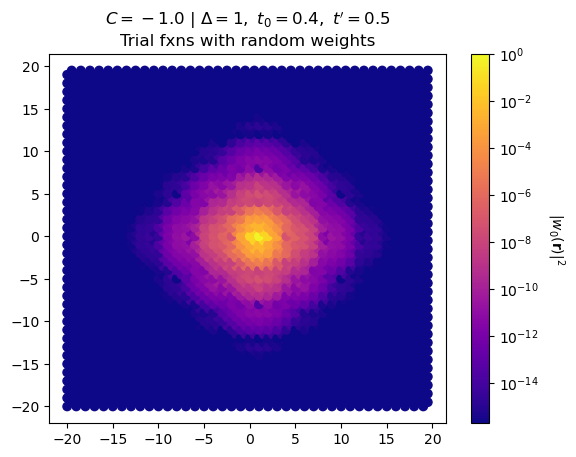

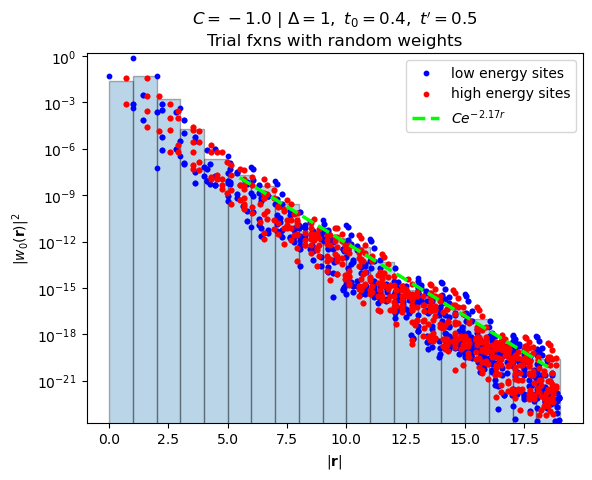

([<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 1 Axes>],
 [<Axes: title={'center': "$C = -1.0$ | $\\Delta = 1,\\ t_0 = 0.4,\\ t' = 0.5$\nTrial fxns with random weights"}>,
  <Axes: title={'center': "$C = -1.0$ | $\\Delta = 1,\\ t_0 = 0.4,\\ t' = 0.5$\nTrial fxns with random weights"}, xlabel='$|\\mathbf{r}|$', ylabel='$|w_0(\\mathbf{r})|^2$'>])

In [104]:
# title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$"
#         "\n" 
#         rf"Trial fxns on sites {tf_list}"
#          )

title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$"
        "\n" 
        rf"Trial fxns with random weights"
         )
Wan_idx = 0
print(f"Center {Wf_cntrs[Wan_idx].round(7)}")
plot.plot_Wan(W0_max_loc, Wan_idx, orbs, lat_vecs, title=title, plot_decay=True, show=True)